In [18]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)#, module="seaborn._oldcore")

In [19]:
experimentdir1 = rd.datadir/'flow'/'2024.09.09_MEKi_PMA_reprogramming'
experimentdir2 = rd.datadir/'flow'/'2024.09.30_MEKi_PMA_reprogramming'

outputdir = rd.rootdir/'figures'/'PMA+MEKi_reprogramming'

In [3]:
#rd.plot.plot_well_metadata(experimentdir2/'metadata.yaml')


# Load Data

In [20]:
data_columns = ['GFP-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)

df = pd.concat([df1,df2])

df['condition'] = df['PMA'] + ' PMA, ' + df['MEKi'] + ' MEKi'

Get rid of negative values

In [5]:
for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]
df

,rep,infection,MEKi,PMA,well,population,GFP-A,condition
0,A,NIL SNAP-DD,0 uM,0 nM,A1,Single Cells,14606.0,"0 nM PMA, 0 uM MEKi"
3,A,NIL SNAP-DD,0 uM,0 nM,A1,Single Cells,63170.0,"0 nM PMA, 0 uM MEKi"
7,A,NIL SNAP-DD,0 uM,0 nM,A1,Single Cells,146.0,"0 nM PMA, 0 uM MEKi"
8,A,NIL SNAP-DD,0 uM,0 nM,A1,Single Cells,44.0,"0 nM PMA, 0 uM MEKi"
9,A,NIL SNAP-DD,0 uM,0 nM,A1,Single Cells,2672.0,"0 nM PMA, 0 uM MEKi"
...,...,...,...,...,...,...,...,...
1275371,D,NIL SNAP-DD,0.1 uM,0 nM,F9,Single Cells,18051.0,"0 nM PMA, 0.1 uM MEKi"
1275372,D,NIL SNAP-DD,0.1 uM,0 nM,F9,Single Cells,10985.0,"0 nM PMA, 0.1 uM MEKi"
1275373,D,NIL SNAP-DD,0.1 uM,0 nM,F9,Single Cells,11.0,"0 nM PMA, 0.1 uM MEKi"
1275375,D,NIL SNAP-DD,0.1 uM,0 nM,F9,Single Cells,2822.0,"0 nM PMA, 0.1 uM MEKi"


# iMN gate

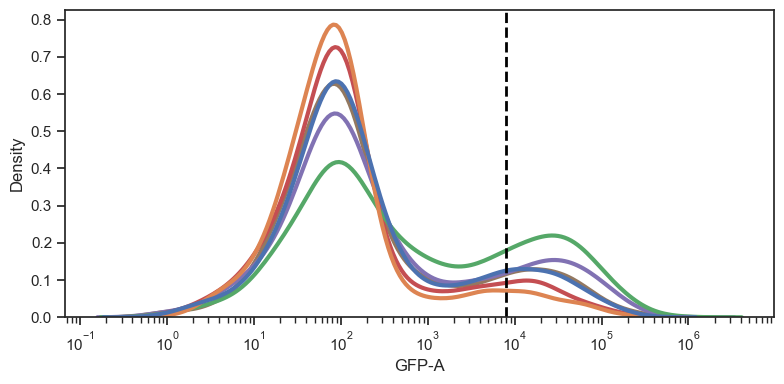

In [11]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3

# Another option is to make a gate based on a control condition (e.g. no color)
#reprogrammed_gate = df[df.condition == 'MEF']['eGFP-A'].quantile(0.9999)

# Plot gate
fig=plt.figure(figsize=(8,4))
g = sns.kdeplot(data=df.sample(10000),x='GFP-A',hue='condition',log_scale=True,common_norm=False,linewidth=3,legend=False)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
fig.tight_layout()
plt.show()


# Make summary statistics dataframe

In [12]:
# Make a dataframe with summary statistics such as mean fluorescent intensity (MFI)
groups = ['rep','MEKi','PMA','condition','well']

summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Single Cells Count')#,
    ], axis=1)
summary_df = summary_df.reset_index()

# Statistics you would like to plot later
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

# Plotting Functions

In [13]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        labels = [ '\n'.join(wrap(l, 6)) for l in order]
        #labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)


def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        labels = [ '\n'.join(wrap(l, 16)) for l in order]
        #labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def scatter(xcat,ycat,data,order,hue,savetitle,figsize=(7,4),palette='muted',sci=None,log='none',xlim=None,ylim=None):
    xcatSEM = xcat + ' SEM'
    ycatSEM = ycat + ' SEM'

    # Make the figure
    fig, ax = plt.subplots(figsize=figsize)
    plt.errorbar(x=xcat, y=ycat, xerr=xcatSEM, 
                yerr=ycatSEM,data=data, capsize=2, elinewidth=0.7,capthick=0.7,ls='none',color='grey')

    # Make the dots
    sns.scatterplot(data=data, x=xcat, y=ycat, hue=hue,hue_order=order,palette=palette,zorder=3,s=100)

    # Remove error bars from the legend
    handles, labels = ax.get_legend_handles_labels()
    handles[-1] = []
    labels[-1]= []
    ax.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Change axis limit
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Change x and y axes to log or scientific notation as desired
    if sci != None:
        plt.ticklabel_format(axis=sci,style='sci',scilimits=(0,0))
    if 'x' in log:
        ax.set_xscale('log')
    if 'y' in log:
        ax.set_yscale('log')
    plt.tight_layout()    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

# Plot Results

Formatting

In [14]:
sns.set_theme(style="ticks",font_scale=1)
savedict = {'(%) iMN yield\nper MEF plated':'(%) iMN yield per MEF plated',
            '(%) iMN\nof all cells':'(%) iMN of all cells',
            'Single Cells Count':'Single Cells Count'}

#palette_MEKi = {'0 uM':'','0.1 uM':'','1 uM':''}
palette_PMA = {'0 nM':'grey','100 nM':'#cc75ab'}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.1 uM_0 nM vs. 0.1 uM_100 nM: t-test independent samples, P_val:1.033e-03 t=-3.779e+00
0 uM_0 nM vs. 0 uM_100 nM: t-test independent samples, P_val:3.408e-10 t=-1.071e+01
1 uM_0 nM vs. 1 uM_100 nM: t-test independent samples, P_val:8.523e-05 t=4.802e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.1 uM_0 nM vs. 0.1 uM_100 nM: t-test independent samples, P_val:6.481e-03 t=-3.008e+00
0 uM_0 nM vs. 0 uM_100 nM: t-test independent samples, P_val:1.604e-09 t=-9.845e+00
1 uM_0 nM vs. 1 uM_100 nM: t-test independent samples, P_val:1.892e-02 t=2.534e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     **

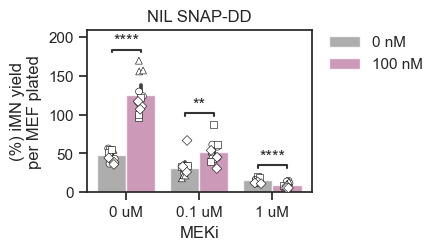

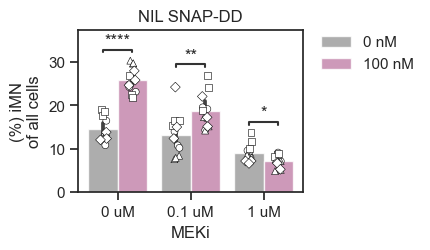

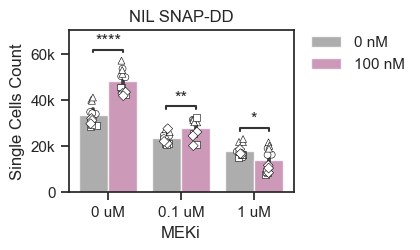

In [17]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

order = ['NIL','NIL DD','NIL RIDD','NIL RISDD']
hue_order = ['0 nM', '0.1 uM', '1 uM','5 uM', '10 uM']
PMA_order = ['0 nM','100 nM']
MEKi_order = ['0 uM','0.1 uM','1 uM']
palette_PMA = {'0 nM':'#999999','100 nM':'#cc75ab'}
pairs = [(('0 uM', '0 nM'),('0 uM','100 nM')),
          (('0.1 uM', '0 nM'),('0.1 uM','100 nM')),
          (('1 uM', '0 nM'),('1 uM','100 nM'))]

for i in data2plot:
    savetitle = 'barplot_PMA-hue_' + savedict[i]
    custom_barplot('MEKi',i,summary_df,
                    savetitle,
                    hue='PMA',
                    hue_order=PMA_order,
                    order = MEKi_order,
                    palette=palette_PMA,
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    plottitle='NIL SNAP-DD',
                    xlabel='MEKi',
                    pairs=pairs
        )